In [1]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam
import argparse
import pickle
import cv2
import os


In [2]:
datapath="C:/Users/EGYPT_LAPTOP/Downloads/egyptian_dataset"
outputlabelbinarizer="D:/"
outputmodel="D:/"
n_epochs=50
# initialize the set of labels from the spots activity dataset we are
# going to train our network on
LABELS = set(["Ibn Tolon Mosque","Samaan The Tanner Church","Sultan Hassan Mosque","Amr ibn Al-Aas Mosque","Babylon Fortress","Cavern Church- Abu Serga","Hanging Church"])

In [3]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(datapath))
data = []
labels = []

[INFO] loading images...


In [4]:
i=0
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	i=i+1
	# if the label of the current image is not part of of the labels
	# are interested in, then ignore the image
	if label not in LABELS:
		print(label)
		break

	# load the image, convert it to RGB channel ordering, and resize
	# it to be a fixed 224x224 pixels, ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	# # update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
print(i)


Refaay Mosque
2642


In [5]:
data = np.array(data)
labels = np.array(labels)
# initialize the Rectified Adam optimizer
# print("[INFO] using Rectified Adam optimizer")
# opt = Adam(total_steps=5000, warmup_proportion=0.1, min_lr=1e-5)

In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)


In [7]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.25, stratify=labels, random_state=42)



In [8]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [9]:
# load the ResNet-50 network, ensuring the head FC layer sets are left
# off
baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


In [10]:

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(lb.classes_), activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)


In [11]:
for layer in baseModel.layers:
	layer.trainable = False

# compile our model (this needs to be done after our setting our
# layers to being non-trainable)
print("[INFO] compiling model...")
# opt = SGD(lr=1e-4, momentum=0.9, decay=1e-4 / n_epochs)
model.compile(loss="categorical_crossentropy",optimizer=optimizers.Adam(lr=1e-05),
	metrics=["accuracy"])


[INFO] compiling model...


In [12]:
print("[INFO] training head...")
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
model_checkpoint = ModelCheckpoint('modelOpt.h5', monitor='val_acc',verbose=1, save_best_only=True)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='max')
H = model.fit(
	x=trainAug.flow(trainX, trainY, batch_size=32),
	steps_per_epoch=len(trainX) // 32,
	validation_data=valAug.flow(testX, testY),
	validation_steps=len(testX) // 32,
	epochs=n_epochs)


[INFO] training head...
Epoch 1/50
61/61 [==============================] - 348s 6s/step - loss: 2.0703 - accuracy: 0.2464 - val_loss: 1.4253 - val_accuracy: 0.4125
Epoch 2/50
61/61 [==============================] - 422s 7s/step - loss: 1.6069 - accuracy: 0.3727 - val_loss: 1.1463 - val_accuracy: 0.5688
Epoch 3/50
61/61 [==============================] - 420s 7s/step - loss: 1.3838 - accuracy: 0.4615 - val_loss: 0.9722 - val_accuracy: 0.6484
Epoch 4/50
61/61 [==============================] - 414s 7s/step - loss: 1.2469 - accuracy: 0.5241 - val_loss: 0.8588 - val_accuracy: 0.6828
Epoch 5/50
61/61 [==============================] - 376s 6s/step - loss: 1.0706 - accuracy: 0.5739 - val_loss: 0.7740 - val_accuracy: 0.7297
Epoch 6/50
61/61 [==============================] - 353s 6s/step - loss: 1.0275 - accuracy: 0.6001 - val_loss: 0.7253 - val_accuracy: 0.7484
Epoch 7/50
61/61 [==============================] - 353s 6s/step - loss: 0.9250 - accuracy: 0.6535 - val_loss: 0.6623 - val_accura

In [13]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(x=testX.astype("float32"), batch_size=32)



[INFO] evaluating network...


In [14]:
print(classification_report(
	testY.argmax(axis=1),predictions.argmax(axis=1), target_names=lb.classes_, digits = 6))
print(testY.argmax(axis=1))

                          precision    recall  f1-score   support

   Amr ibn Al-Aas Mosque   0.931507  1.000000  0.964539       136
        Babylon Fortress   1.000000  0.993548  0.996764       155
Cavern Church- Abu Serga   0.904412  0.924812  0.914498       133
          Hanging Church   0.923077  0.934132  0.928571       167
        Ibn Tolon Mosque   1.000000  0.800000  0.888889        70

                accuracy                       0.945537       661
               macro avg   0.951799  0.930498  0.938652       661
            weighted avg   0.947240  0.945537  0.944928       661

[1 2 2 1 0 4 2 0 2 0 1 2 0 2 4 1 0 1 2 4 0 3 2 3 0 0 1 1 4 1 3 3 0 1 1 4 4
 2 3 3 2 1 2 2 2 3 0 4 2 2 1 3 1 0 1 2 0 3 3 3 3 3 2 3 0 1 2 2 0 3 4 1 0 1
 3 3 4 1 3 0 0 2 0 3 0 1 2 0 3 0 3 1 4 3 3 3 0 0 3 1 4 0 0 3 3 1 4 3 0 1 2
 0 3 0 1 0 2 0 2 1 4 3 4 4 4 2 1 1 2 3 2 1 1 3 1 2 0 0 4 3 4 3 0 1 0 4 4 4
 3 2 0 2 1 1 2 1 2 2 3 0 2 0 2 2 0 3 3 3 3 2 2 2 3 1 0 2 4 0 2 0 3 2 2 1 0
 3 0 4 3 0 0 1 1 2 1 0 1 3 3

In [15]:
from collections import Counter
Counter(testY.argmax(axis=1))
Counter(predictions.argmax(axis=1))

Counter({1: 154, 2: 136, 0: 146, 4: 56, 3: 169})

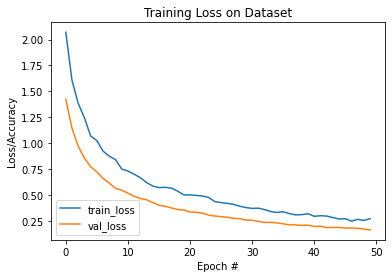

In [16]:
plt.figure()
plt.plot( H.history["loss"], label="train_loss")
plt.plot( H.history["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()  

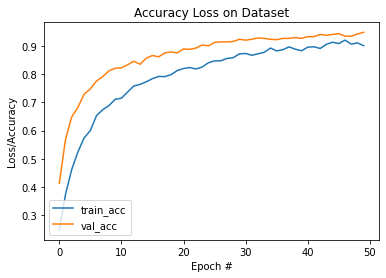

In [17]:
plt.figure()
plt.plot( H.history["accuracy"], label="train_acc")
plt.plot( H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

plt.show()


In [18]:

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc



<ipython-input-19-4f0efed2a45c>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


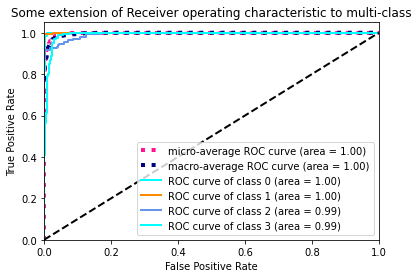

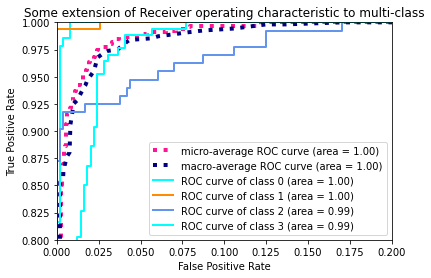

In [19]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
#y_score = model.predict(testX)
y_score=predictions
n_classes=4
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testY[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(testY.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [20]:
# serialize the model to disk
print("[INFO] serializing network...")
model.save('D:/model.h5', save_format="h5")
# serialize the label binarizer to disk
f = open('D:/pickle.pickle', "wb")
f.write(pickle.dumps(lb))
f.close()
with open('D:/Egypt_label.txt', 'w') as filehandle:
    filehandle.writelines("%s\n" % LABELS for LABELS in LABELS)

[INFO] serializing network...


In [22]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
# with open('model.tflite', 'wb') as f:
#   f.write(tflite_model)
f=open("D:/5juneEgypt.tflite","wb")
f.write(tflite_model)
f.close()

INFO:tensorflow:Assets written to: C:\Users\EGYPT_~1\AppData\Local\Temp\tmpneheclee\assets
INFO:tensorflow:Assets written to: C:\Users\EGYPT_~1\AppData\Local\Temp\tmpneheclee\assets
